<a href="https://colab.research.google.com/github/geraldlab/nlp_machine_learning/blob/main/convnet_cats_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                Using Pre-trained Convolutional Neural Networks  model to classify images



>  *Author: Gerald Kandulu, January 2021*




**1.0 Introduction**

This notebook demostrates implementation of transfer learning in Deep learning to classify images. The goal of image classification is to classify a specific picture according to a set of possible categories. One of the neural networks that is used for image classification is Convolutional Neural Networks aka convnets. 

In general, convnets excels in a wide range of computer vision tasks (Chollet, 2017). Also, Convnets are gaining more popularity due to their high performance and ease of training. A typical convnets has two parts:

1. **Convolutional base** is made of a stack of convolutional and pooling layers that learns generic concepts of the input image. This makes the feature map learnt by the convolutional base to be useful regardless of the computer-vision problem at hand.

2. **Classifier** is made of fully connected layers and their main goal to classify the image based on the detected features. Thus, the feature learnt by the classifier are usually specific to the set of classes on which the model was trained on. 

*It should be noted that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eyes").*

 

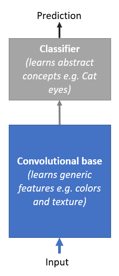
        *Fig. 1: Typical convnet*

This notebook will demostrate use of transfer learning by using a pre-trained convolutional base and training a classifier. This demo will use the classic example of image classification, whose objective is to classify whether images contain either a dog or a cat. The images of the cats and dogs are taken from the "[Kaggle Dogs vs. Cats classification Competition](https://www.kaggle.com/c/dogs-vs-cats)". The code in this notebook has been adapted from Chollet (2017).

**2. Prepare the environment**

Below code configures the notebook to connect to Kaggle.com by installing the Kaggle library and making Kaggle API key accessible to this notebook. 

Note: Before running below code make sure you have downloaded and uploaded your Kaggle API key ([Easiest way to download kaggle data in Google Colab ](https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463) )

In [1]:
#to be run first time 
! pip install -q kaggle

In [2]:
import os

#folder to save kaggle api key: 
rt_kaggle = "/root/.kaggle"

if not os.path.isdir(rt_kaggle):
    os.mkdir(rt_kaggle)

! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

**3.0 Load Data**

Below code downloads the datasets from the **Kaggle: Dogs vs. Cats competition**




In [3]:
#download the dogs-vs-cats competion
! kaggle competitions download -c 'dogs-vs-cats'


  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 29.7MB/s]
 96% 524M/543M [00:02<00:00, 286MB/s]
100% 543M/543M [00:02<00:00, 249MB/s]
 91% 247M/271M [00:01<00:00, 219MB/s]
100% 271M/271M [00:01<00:00, 213MB/s]


In [4]:
%%capture cell_output
#extract the training and test datasets
import os

dogs_vs_cats =  os.path.join('/content', 'dogs_vs_cats')

if not os.path.isdir(dogs_vs_cats):
    os.mkdir(dogs_vs_cats)


In [5]:
%%capture cell_output
#unzip training dataset to 'dogs_vs_cats' folder
! unzip train.zip -d dogs_vs_cats

#rename train folder
src_train = os.path.join(dogs_vs_cats, 'src_train')

os.rename(os.path.join(dogs_vs_cats, 'train'), src_train)

In [6]:
%%capture cell_output
#unzip test dataset to 'dogs_vs_cats' folder
! unzip test1.zip -d dogs_vs_cats

! cp sampleSubmission.csv /content/dogs_vs_cats

In [7]:
#clean environment
!rm test1.zip train.zip sampleSubmission.csv

**4.0 Exploratory Data Analysis**

The dogs_vs_cats folder has 25,000 and 12,500 files in the training and testing folders as specified by the kaggle competition description.

In [8]:
test_dir = os.path.join(dogs_vs_cats, 'test1')

print('# of files in train folder: ', len(os.listdir(src_train)))
print('# of files in test folder: ', len(os.listdir(test_dir)))

# of files in train folder:  25000
# of files in test folder:  12500


In [9]:
#help function to display images in a grid
import matplotlib.image as mpimg
from keras.preprocessing import image
import matplotlib.pyplot as plt

def display_images_grid(images, img_folder, has_class_label=False, row_col_ind=(4, 4, 0)):
    #rows, cols, i = 4, 4, 0
    rows, cols, i = row_col_ind
    
    fig = plt.figure(figsize=(12, 12))

    for fname in images [: rows * cols]:
        plt.subplot(rows, cols,i+1)
        plt.title(fname)
        plt.xticks([]), plt.yticks([])
        plt.tight_layout()
        
        if has_class_label:
            fname = fname.split('/')[0].strip()
            
        img = image.load_img(os.path.join(img_folder, fname), target_size=(150, 150))
        plt.imshow(img)
        i += 1
        
    return plt

Below code displays 8 random files from the training folder.

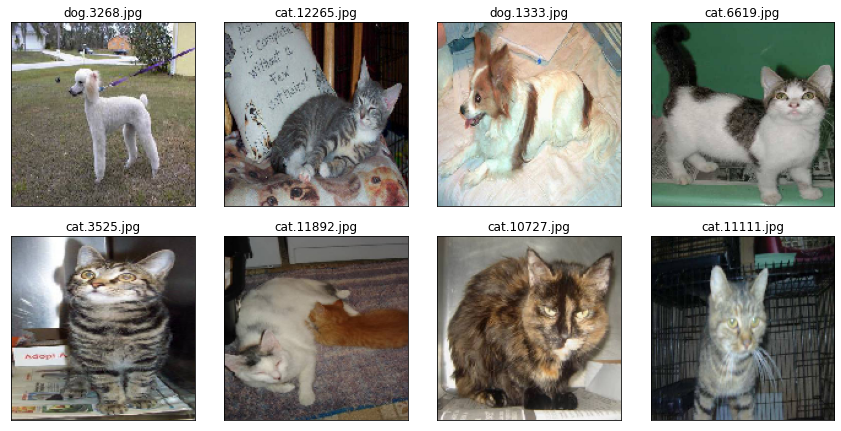

In [10]:
import random

random.seed(1234)

#view 8 random images from the source training folder
plt = display_images_grid(images=random.sample(os.listdir(src_train), 8), img_folder=src_train)

plt.show()

As can be observed, the prefix 'cat/ dog' is used to indicate if the image is for a cat or a dog.

**5. Model Training **

As indicated, transfer learning will be used in this demo by using a pre-trained convnet. The convolutional base of the model will be frozen so that its weights are not modified when training the classifier for the task of identify an image of a cat or dog. This will be done on a subset of 4,200 images (3000 training, 1000 validation and 200 holdout) with an even distribution of each class in the set. 

The code below creates the 3 folder and their sub-folders.



In [11]:
#training folders
train_dir = os.path.join(dogs_vs_cats, "train")
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

train_cats = os.path.join(train_dir, "cats")
if not os.path.isdir(train_cats):
    os.mkdir(train_cats)

train_dogs = os.path.join(train_dir, "dogs")
if not os.path.isdir(train_dogs):
    os.mkdir(train_dogs)

#validation folders   
validation_dir = os.path.join(dogs_vs_cats, "validation")
if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

val_cats = os.path.join(validation_dir, "cats")
if not os.path.isdir(val_cats):
    os.mkdir(val_cats)

val_dogs = os.path.join(validation_dir, "dogs")
if not os.path.isdir(val_dogs):
    os.mkdir(val_dogs)

#hold_out folder
hold_out = os.path.join(dogs_vs_cats, "hold_out")
if not os.path.isdir(hold_out):
    os.mkdir(hold_out)

Code below copies the a random sample of images from the training folder to respective folder.

In [12]:
import re

src_trn_files = os.listdir(src_train)

#list of file names with cat images from train dir
cat_files = [src_trn_files[i] for i, x in enumerate(src_trn_files) if re.match(r'^cat', x)]

#list of file names with dog images from train dir
dog_files = [src_trn_files[i] for i, x in enumerate(src_trn_files) if re.match(r'^dog', x)]

In [13]:
#random sample 2100 cats image file names
cat_files = random.sample(cat_files, 2100)

#random sample 2100 dogs image file names
dog_files = random.sample(dog_files, 2100)

import shutil

#copy cats images to train_cats folder
for fname in cat_files[:1500]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(train_cats, fname)
    shutil.copyfile(src, dst)
    
#copy cats images to val_cats folder
for fname in cat_files[1500:2000]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(val_cats, fname)
    shutil.copyfile(src, dst)
 
#copy dogs images to train_dog folder
for fname in dog_files[:1500]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(train_dogs, fname)
    shutil.copyfile(src, dst)

#copy dogs images to val_dogs folder
for fname in dog_files[1500:2000]:
    src = os.path.join(src_train, fname)
    dst = os.path.join(val_dogs, fname)
    shutil.copyfile(src, dst)
    
#copy dogs & cats images to hold_out folder
for fname in cat_files[2000:] + dog_files[2000:] :
    src = os.path.join(src_train, fname)
    dst = os.path.join(hold_out, fname)
    shutil.copyfile(src, dst)

Below code creates data generators for train and validation. To help avoid overfitting, data augmentation was applied to the training generator.

In [14]:
#define data augmentation on training data
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
#create data generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


To build the model, first a pre-trained model was downloaded from keras. Below code downloads the pre-trained model and freezes the convolutional base.

In [16]:
#install VGG conv base
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

#freeze the conv_base - so that weights are not changed during training
conv_base.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


Below code build a model and trains the model end -to -end with a frozen convolutional base.


In [17]:
#build model using frozen conv_base and adding a classifier layer
from tensorflow.keras import optimizers

model = keras.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu", input_dim=4 * 4 * 512))
model.add(layers.Dense(1, activation="sigmoid"))

#compile the model
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

#train the model
history = model.fit(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50)


Epoch 1/30
100/100 [==============================] - 27s 187ms/step - loss: 0.6526 - acc: 0.6050 - val_loss: 0.4409 - val_acc: 0.8540
Epoch 2/30
100/100 [==============================] - 18s 183ms/step - loss: 0.5060 - acc: 0.7714 - val_loss: 0.3516 - val_acc: 0.8740
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.4455 - acc: 0.8129 - val_loss: 0.3070 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 18s 184ms/step - loss: 0.4291 - acc: 0.7886 - val_loss: 0.2882 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 18s 185ms/step - loss: 0.3803 - acc: 0.8401 - val_loss: 0.2675 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 18s 183ms/step - loss: 0.3970 - acc: 0.8113 - val_loss: 0.2569 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 18s 185ms/step - loss: 0.3544 - acc: 0.8392 - val_loss: 0.2560 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 1

Below code plots the accuracy and loss of the model on training and validation sets.

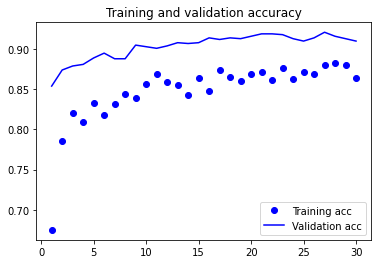

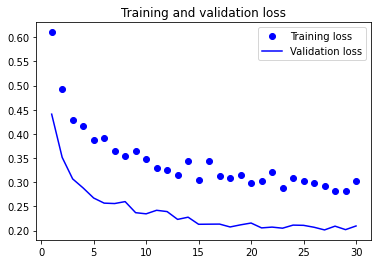

In [18]:
#display loss & accuracy curves of the model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**6. Test the model**

In [19]:
from keras.preprocessing import image
import numpy as np

#function to convert images in folder to tensors
def convert_imgs_to_tensors(img_folder):
  # dimensions of images
  img_width, img_height = 150, 150

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

Below code run the model on the hold out set.

In [20]:
images = convert_imgs_to_tensors(hold_out)
#make predictions
predictions = [int(round(p[0])) for p in model.predict(images, batch_size=10)]

Below code decodes the predictions

In [21]:
#decode the predictions
labels = (train_generator.class_indices)

#switch key and values
reversed_dict = dict(map(reversed, labels.items()))

#get the predicted labels
predicted_labels = [reversed_dict[v1][:3] for k, v1 in enumerate(predictions)]

In [22]:
#store predictions in pandas dataframe
import pandas as pd

df = pd.DataFrame({'filename': os.listdir(hold_out),
                             'predicted_label': predicted_labels})

df['Correct_pred'] = df['predicted_label'].eq(df['filename'].str[:3]).astype(int)
df['fname_pred_label'] = df['filename'] +  ' / Pred. label: ' + df['predicted_label']
df

,filename,predicted_label,Correct_pred,fname_pred_label
0,dog.11711.jpg,dog,1,dog.11711.jpg / Pred. label: dog
1,dog.2773.jpg,dog,1,dog.2773.jpg / Pred. label: dog
2,cat.4162.jpg,cat,1,cat.4162.jpg / Pred. label: cat
3,cat.10183.jpg,cat,1,cat.10183.jpg / Pred. label: cat
4,dog.8438.jpg,cat,0,dog.8438.jpg / Pred. label: cat
...,...,...,...,...
195,cat.10789.jpg,cat,1,cat.10789.jpg / Pred. label: cat
196,dog.163.jpg,dog,1,dog.163.jpg / Pred. label: dog
197,cat.11324.jpg,cat,1,cat.11324.jpg / Pred. label: cat
198,cat.8226.jpg,cat,1,cat.8226.jpg / Pred. label: cat


Below code, displays first 12 images that were misclassified from the hold out set.

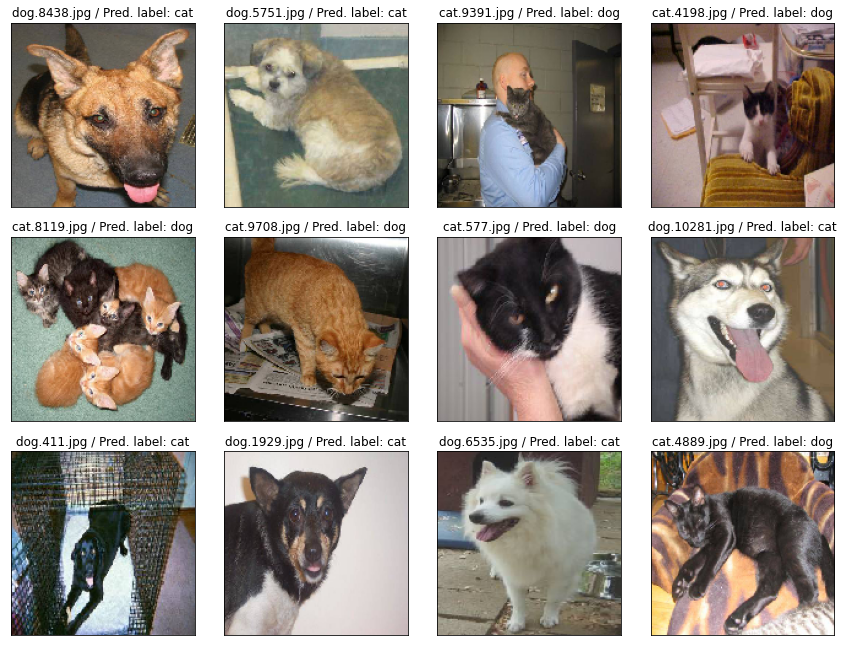

In [24]:
#list of misclassified images from hold out set
mis_class_img = df[df['Correct_pred'] == 0]['fname_pred_label'].head(12).to_list()

#display the 12 images and their labels in grid
plt = display_images_grid(images = mis_class_img, img_folder=hold_out, has_class_label=True)

plt.show()

**6.1. Run model on test images**

Below code runs the model on the test images and store the result in a format ready for submission to the Kaggle competition.

In [25]:
images = convert_imgs_to_tensors(test_dir)
#make predictions
predictions = [int(round(p[0])) for p in model.predict(images, batch_size=10)]

#get the label
predicted_labels = [reversed_dict[v1][:3] for k, v1 in enumerate(predictions)]

In [26]:
#store the predictions in dataframe
df = pd.DataFrame({'filename': os.listdir(test_dir), 'label': predictions,
                             'predicted_label': predicted_labels})

#extract id from file name for kaggle submission
df['id'] = df['filename'].str.split('.').str[0]

#column to store file name and prediction
df['fname_pred_label'] = df['filename'] +  ' / Pred. label: ' + df['predicted_label']

#subset columns required for kaggle submission
df0 = df[['id', 'label']]

#export to csv file
df0.to_csv('submission.csv', index=False)
df0

,id,label
0,3537,0
1,1243,0
2,4267,1
3,11509,0
4,7547,1
...,...,...
12495,1278,0
12496,8603,1
12497,7906,1
12498,12310,0


Display 12 random images and their predictions from the test set

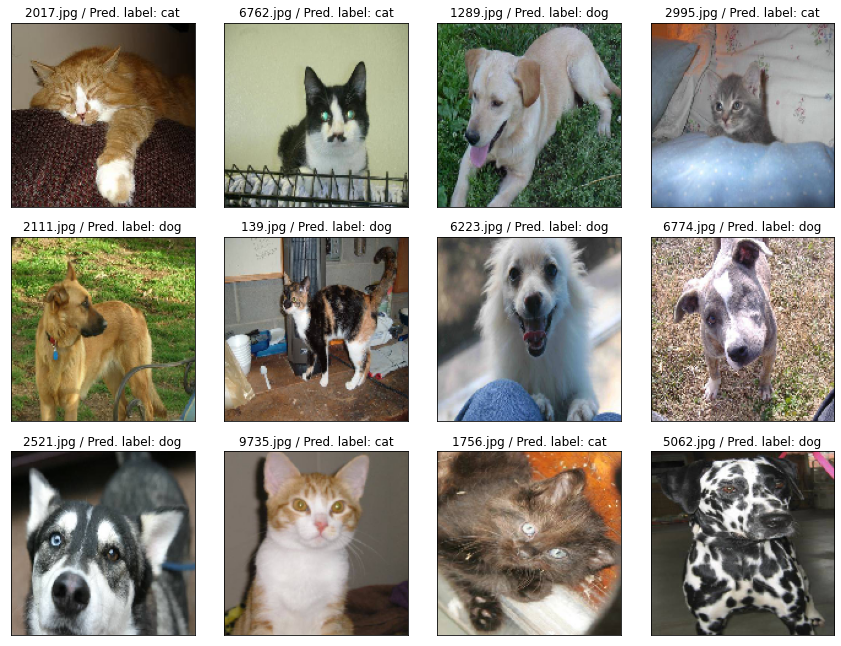

In [27]:
#get 12 random images from misclassified set
img_preds =  random.sample(df['fname_pred_label'].to_list(), 12)

#display the 12 random images and their labels in grid
plt = display_images_grid(images = img_preds, img_folder=test_dir, has_class_label=True)

plt.show()

**7.0 Conclusion**

This notebook has demonstrated how to classify images of cats and dogs through transfer learning. The modeled achieved **90.5 %** accuracy on the hold out set. The model used data augmentation and a frozen convolutional base.

**Reference**

Bonner, A 2018, Setting Up Kaggle in Google Colab, url: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b6146

Chollet, F., 2017. Deep learning with python. Manning Publications Co